# Load ds005514 and start training

In [1]:
from eegdash import EEGDash
from eegdash.data_utils import RawEEGDash

eegdashdata = EEGDash(is_public=False)
records = eegdashdata.find({'dataset': 'ds005514'}) # current call
# records = eegdashdata.find(mongodb={'dataset': 'ds005514'}, description=['age', 'gender']) # braindecode call

In [17]:
from braindecode.datasets import BaseDataset, BaseConcatDataset
gender_to_label = {gender: i for i, gender in enumerate(['M','F'])}

allEEGDash = []
records[0]
for record in records:
    s3_path = eegdashdata.get_s3path(record)
    sfreq = record['sampling_frequency']
    nchans = record['nchans']
    ntimes = record['ntimes']
    ch_names = record['channel_names']
    ch_types = record['channel_types']
    s3_path = eegdashdata.get_s3path(record)
    eegdash = BaseDataset(RawEEGDash(s3_path, {'sfreq': sfreq, 'nchans': nchans, 'n_times': ntimes, 'ch_types': ch_types, 'ch_names': ch_names}, preload=False))
    eegdash.set_description({'age': record['participantinfo']['age'], 'gender': record['participantinfo']['gender'], 'subject': record['subject']})
    eegdash.target_name = 'gender'
    allEEGDash.append(eegdash)


In [18]:
eegdash_braindecode = BaseConcatDataset(allEEGDash)

In [19]:
import numpy as np

res = eegdash_braindecode.description
res

,age,gender,subject
0,5.7012,M,NDARRW481GFE
1,5.7012,M,NDARRW481GFE
2,5.7012,M,NDARRW481GFE
3,5.7012,M,NDARRW481GFE
4,5.7012,M,NDARRW481GFE
...,...,...,...
2880,8.7819,M,NDARLM877UZM
2881,8.7819,M,NDARLM877UZM
2882,8.7819,M,NDARLM877UZM
2883,8.7819,M,NDARLM877UZM


In [20]:
dataiter = iter(eegdash_braindecode)
first_item, label = dataiter.__next__()
label

'M'

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
sampling_freq: 500.0
(array([[-9376.84082031, -9362.90234375, -9362.58203125, ...,
        -6450.82470703, -6452.08105469, -6455.24609375]]), array([ 10.   ,  10.002,  10.004, ..., 322.518, 322.52 , 322.522]))
-9783.4443359375 -5796.91552734375


c:\Users\adelorme\AppData\Local\anaconda3\envs\gpu-test\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


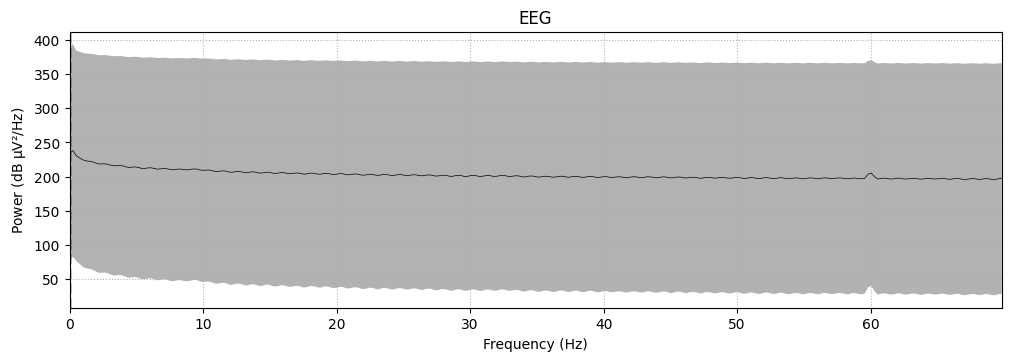

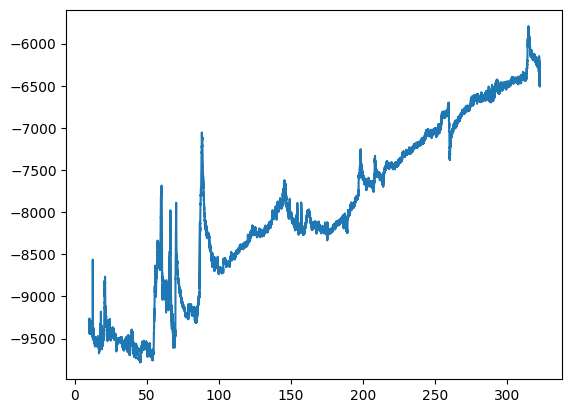

In [21]:
import matplotlib.pyplot as plt

raw = eegdash_braindecode.datasets[1].raw
fig = raw.compute_psd(fmax=70).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
sampling_freq = raw.info["sfreq"]
print('sampling_freq:', sampling_freq)
start_stop_seconds = np.array([10, 500])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]
print(raw_selection)
x = raw_selection[1]
y = raw_selection[0].T
print(np.min(y),np.max(y))
plt.figure()
plt.plot(x, y)
plt.show()

In [22]:
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows)
windows_ds = create_fixed_length_windows(eegdash_braindecode, start_offset_samples=0, stop_offset_samples=None,
        window_size_samples=614,
        window_stride_samples=1000, drop_last_window=True,
        preload=False)

In [ ]:
# do not run this cell

import os
from braindecode.datautil import load_concat_dataset

# probe user to continue by entering y
response = input("Press 'y' to continue: ")
if response.lower() != 'y':
    print("Loading data from disk")
    windows_ds = load_concat_dataset(path='data/hbn_preprocessed_windowed_scaled', preload=True)
else:
    # laod all the data
    for iWin in range(len(windows_ds)):
        res = windows_ds[iWin][0].shape
    os.makedirs('data/hbn_preprocessed_windowed_scaled', exist_ok=True)
    windows_ds.save('data/hbn_preprocessed_windowed_scaled', overwrite=True)


In [23]:
dataiter = iter(windows_ds)
first_item, label = dataiter.__next__() # question why is the label lost here 
print(f"Type: {type(first_item)}")
print(f"Length: {len(first_item) if isinstance(first_item, (list, tuple)) else 'N/A'}")
print(f"Content: {first_item}")

ValueError: too many values to unpack (expected 2)

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
random_state = 42
subjects = np.unique(windows_ds.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)

AttributeError: 'EEGWindowsDataset' object has no attribute 'get_data'